# MNIST DATASET

In [2]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , regularizers
from tensorflow.keras.datasets import mnist,cifar10
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


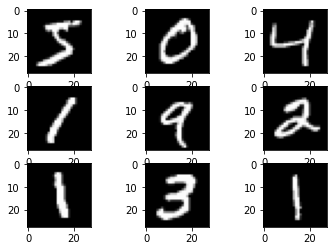

In [2]:
## Visualizing
from matplotlib import pyplot

(x_train,y_train) , (x_test , y_test) = mnist.load_data()

for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [3]:
## MLP Model

(x_train,y_train) , (x_test , y_test) = mnist.load_data()
x_train=x_train.reshape(-1 , 28*28).astype("float32")/255.0
x_test = x_test.reshape(-1 , 28*28).astype("float32")/255.0
model = keras.Sequential([
    keras.layers.InputLayer((28*28)),
    layers.Dense(64 , activation='relu'),
    layers.Dense(64 , activation='relu'),
    layers.Dense(64 , activation='relu'),
    layers.Dense(64 , activation='relu'),
    layers.Dense(10)
])
print(model.summary())

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001) ,
    metrics=["accuracy"])

model.fit(x_train,y_train , batch_size=32 , epochs=20 , verbose=2 , validation_split=0.2 )
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 63,370
Trainable params: 63,370
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1500/1500 - 5s - loss: 0.3111 - accuracy: 0.9057 - val_loss: 0.1478 - val_accuracy: 0.9579
Epoch 2/20


In [32]:
# GRU , LSTM Model
(x_train,y_train) , (x_test , y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

model = keras.Sequential()
model.add(keras.layers.InputLayer((None,28)))
model.add(layers.LSTM(128 , return_sequences=True, activation='tanh'))
model.add(layers.GRU(128 , activation='tanh'))
model.add(layers.Dense(10))

model.summary()

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

model.fit(x_train,y_train , batch_size=32 , epochs=20 , verbose=2 , validation_split=0.2 )
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 128)         80384     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_102 (Dense)            (None, 10)                1290      
Total params: 180,746
Trainable params: 180,746
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1500/1500 - 9s - loss: 0.3284 - accuracy: 0.8907 - val_loss: 0.1029 - val_accuracy: 0.9698
Epoch 2/20
1500/1500 - 7s - loss: 0.0941 - accuracy: 0.9712 - val_loss: 0.0783 - val_accuracy: 0.9776
Epoch 3/20
1500/1500 - 7s - loss: 0.0647 - accuracy: 0.9801 - val_loss: 0.0486 - val_accuracy: 0.9862
Epoch 4/20
1500/1500 - 7s - loss: 0.0504 - accuracy: 0.9844 - val_loss:

In [33]:
## ResNet Like Model
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train=x_train.reshape(-1,28,28,1).astype('float32')/255.0
x_test=x_test.reshape(-1,28,28,1).astype('float32')/255.0

## CNNBlock
class CNNBlock(layers.Layer):
    def __init__(self, out_channels, kernel_size=3):
        super(CNNBlock, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, padding="same")
        self.bn = layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x

## ResNet
class ResBlock(layers.Layer):
    def __init__(self,channels):
        super(ResBlock,self).__init__()
        self.cnn1= CNNBlock(channels[0])
        self.cnn2= CNNBlock(channels[1])
        self.cnn3= CNNBlock(channels[2])
        self.pooling= layers.MaxPooling2D()
        self.identity_map=layers.Conv2D(channels[1] , 1 , padding='same')
    
    def call(self,input_tensor,training=False):
        x = self.cnn1(input_tensor , training=training)
        x = self.cnn2(x  , training=training)
        x = self.cnn3( (x + self.identity_map(input_tensor)) , training=training )
        x = self.pooling(x)
        return x

## ResNet_Like Model
class ResNet_Like(keras.Model):
    def __init__(self,num_classes=10):
        super(ResNet_Like, self).__init__()
        self.b1=ResBlock([32 , 32 , 64])
        self.b2=ResBlock([128 , 128 , 256])
        self.b3=ResBlock([128 , 256 , 512])
        self.pool=layers.GlobalAveragePooling2D()
        self.cls=layers.Dense(num_classes)
        
    def call(self,input_tensor ,training=False):
        x = self.b1(input_tensor , training=training)
        x = self.b2(x , training=training )
        x = self.b3(x , training=training )
        x = self.pool(x)
        x = self.cls(x)
        x = tf.nn.softmax(x)
        return x
    
    def model(self):
        x=keras.Input(shape=(28,28,1))
        return keras.Model(inputs=[x] , outputs=self.call(x))
 

model = ResNet_Like()
model.model().summary()    

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

model.fit(x_train,y_train , batch_size=32 , epochs=20 , verbose=2 , validation_split=0.2 )
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
res_block_9 (ResBlock)       (None, 14, 14, 64)        28640     
_________________________________________________________________
res_block_10 (ResBlock)      (None, 7, 7, 256)         526976    
_________________________________________________________________
res_block_11 (ResBlock)      (None, 3, 3, 512)         1839744   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 10)                5130      
_________________________________________________________________
tf.nn.softmax_3 (TFOpLambda) (None, 10)                0   

# CIFAR10 DATASET

In [4]:
from tensorflow.keras.datasets import cifar10

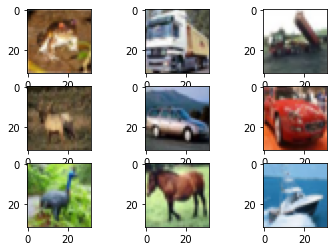

In [5]:
## Visualizing
from matplotlib import pyplot

(x_train,y_train) , (x_test , y_test) = cifar10.load_data()

for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i])
pyplot.show()

In [61]:
## CNN Model

(x_train,y_train) , (x_test , y_test) = cifar10.load_data()
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

inputs=keras.Input(shape=(32,32,3))
x = layers.Conv2D(32 , 3 , padding='same' , kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64 , 3 , padding='same' , kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64 , 3 , padding='same' , kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128 , 3 , padding='same' , kernel_regularizer=regularizers.l2(0.01) )(x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Flatten()(x)
x = layers.Dense(64 , activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x) ##when we are using dropout we should train for a lot more epochs.
outputs = layers.Dense(10)(x)
model=keras.Model(inputs=inputs , outputs=outputs)

model.summary()
#sys.exit()

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ['accuracy'])

model.fit(x_train,y_train , batch_size=32 , epochs=20 , verbose=2 , validation_split=0.2 )
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_100 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
tf.nn.relu_64 (TFOpLambda)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_101 (Bat (None, 16, 16, 64)        256

In [34]:
## VGG Like + Dropout

## VGG Block
class VGGBlock(layers.Layer):
    def __init__(self, out_channels):
        super(VGGBlock, self).__init__()
        self.conv1 = layers.Conv2D(out_channels, (3,3), padding="same", kernel_initializer='he_uniform', activation='relu')
        self.conv2 = layers.Conv2D(out_channels, (3,3), padding="same", kernel_initializer='he_uniform', activation='relu')
        self.pooling = layers.MaxPooling2D()

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.pooling(x)
        return x
    
(x_train,y_train) , (x_test , y_test) = cifar10.load_data()
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

model = keras.Sequential([
    keras.layers.InputLayer((32,32,3)),
    VGGBlock(32),
    layers.Dropout(0.2),
    VGGBlock(64),
    layers.Dropout(0.2),
    VGGBlock(128),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128 , activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(10 , activation='softmax') 
])

model.summary()

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

model.fit(x_train,y_train , batch_size=32 , epochs=100 , verbose=2 , validation_split = 0.2)
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_block_77 (VGGBlock)      (None, 16, 16, 32)        10144     
_________________________________________________________________
dropout_41 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
vgg_block_78 (VGGBlock)      (None, 8, 8, 64)          55424     
_________________________________________________________________
dropout_42 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
vgg_block_79 (VGGBlock)      (None, 4, 4, 128)         221440    
_________________________________________________________________
dropout_43 (Dropout)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 2048)            

In [54]:
## VGG Like + Batch Normalization + Dropout +  "Data Augmentation" :
from tensorflow.keras.utils import to_categorical

(x_train,y_train) , (x_test , y_test) = cifar10.load_data()
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42)

# Augmentation Layer
datagen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_data = datagen.flow(x_train, y_train, batch_size=64)

model = keras.Sequential([
    keras.layers.InputLayer((32,32,3)),
    VGGBlock(32),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    VGGBlock(64),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    VGGBlock(128),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128 , activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10 , activation='softmax') 
])

model.summary()

model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics = ['accuracy'])

model.fit(train_data , batch_size=32 , epochs=100 , verbose=2 ,validation_data=(x_val,y_val) )
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_block_111 (VGGBlock)     (None, 16, 16, 32)        10144     
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_61 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
vgg_block_112 (VGGBlock)     (None, 8, 8, 64)          55424     
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
dropout_62 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
vgg_block_113 (VGGBlock)     (None, 4, 4, 128)       

In [31]:
## Transfer Learning + Data Augmentation :

(x_train,y_train) , (x_test , y_test) = cifar10.load_data()

##Base Model
base=keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3))
base.trainable=False

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),])

inputs = layers.Input([32, 32, 3], dtype = tf.uint8)
x = tf.cast(inputs, tf.float32)
x = data_augmentation(x)
x = tf.keras.applications.vgg19.preprocess_input(x)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128 , activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model=keras.Model(inputs=inputs , outputs=outputs)

print(model.summary())

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

model.fit(x_train,y_train , batch_size=32 , epochs=10 , verbose=2 , validation_split = 0.2)
results = model.evaluate(x_test, y_test, batch_size=32 , verbose=0)
print("**********************")
print(f"test loss = {round(results[0],3)}, test acc = % {round(results[1],3)*100}")


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.cast_19 (TFOpLambda)     (None, 32, 32, 3)         0         
                                                                 
 sequential_21 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 tf.__operators__.getitem_19  (None, 32, 32, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_19 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         200

# CUSTOM DATASET : In this dataset each image contains two numbers

In [35]:
import pandas as pd
import os

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_images = os.getcwd() + "/train_images/" + train_df.iloc[:, 0].values
test_images = os.getcwd() + "/test_images/" + test_df.iloc[:, 0].values

train_labels = train_df.iloc[:, 1:].values
test_labels = test_df.iloc[:, 1:].values


def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    image.set_shape((64, 64, 1))
    label[0].set_shape([])
    label[1].set_shape([])

    labels = {"first_num": label[0], "second_num": label[1]}
    return image, labels


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (
    train_dataset.shuffle(buffer_size=len(train_labels))
    .map(read_image)
    .batch(batch_size=32)
    .prefetch(buffer_size=AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = (
    test_dataset.map(read_image)
    .batch(batch_size=32)
    .prefetch(buffer_size=AUTOTUNE)
)

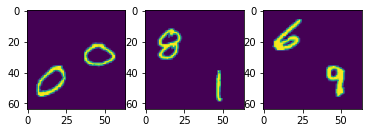

In [54]:
## Visualizing :
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1 = mpimg.imread('train_images/0_00.png')
img2 = mpimg.imread('train_images/0_81.png')
img3 = mpimg.imread('train_images/0_69.png')

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(img1)
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(img2)
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(img3)

In [56]:
# Functional Model
inputs = keras.Input(shape=(64,64,1))
x = layers.Conv2D (
    filters=32 , kernel_size = 3 , padding='same' , kernel_regularizer=regularizers.l2(0.001))(inputs)
x= layers.BatchNormalization()(x)
x= keras.activations.relu(x)
x =  layers.Conv2D (
    filters=64 , kernel_size = 3 , padding='valid' , kernel_regularizer=regularizers.l2(0.001))(x)
x= layers.BatchNormalization()(x)
x= keras.activations.relu(x)
x=layers.MaxPooling2D()(x)
x =  layers.Conv2D (
    filters=64 , kernel_size = 3 , padding='valid' , kernel_regularizer=regularizers.l2(0.001),activation='relu')(x)
x =  layers.Conv2D (128,3,activation='relu')(x)
x=layers.MaxPooling2D()(x)
x=layers.Flatten()(x)
x=layers.Dense(128 , activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(64, activation='relu')(x)
output1=layers.Dense(10 ,activation='softmax', name='first_num')(x)
output2=layers.Dense(10 , activation='softmax', name='second_num')(x)
model=keras.Model(inputs=inputs , outputs= [output1,output2])

print(model.summary())

model.compile(
loss = [keras.losses.SparseCategoricalCrossentropy(),
        keras.losses.SparseCategoricalCrossentropy()],
optimizer=keras.optimizers.Adam(learning_rate=0.001),
metrics=['accuracy'])

model.fit(train_dataset , batch_size=32  ,epochs =10 , verbose=2 , validation_data=test_dataset)
results=model.evaluate(test_dataset, verbose=0)
print("**********************")
print(f"total loss = {round(results[0],3)}, first_num acc = % {round(results[3],3)*100}, second_num acc = % {round(results[4],3)*100}")

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 32)   320         ['input_54[0][0]']               
                                                                                                  
 batch_normalization_49 (BatchN  (None, 64, 64, 32)  128         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.nn.relu_12 (TFOpLambda)     (None, 64, 64, 32)   0           ['batch_normalization_49[0